# Synthetic Hierarchical Dataset

A hierarchical cluster dataset, which is discussed in the
[PaCMAP paper](https://jmlr.org/papers/v22/20-1061.html), but which I couldn't find code for in the
[PaCMAP repo](https://github.com/YingfanWang/PaCMAP/). It must be out there somewhere because it is
also described at <https://sites.duke.edu/dimensionreduction/>:

> The next dataset is the “synthetic hierarchical” dataset. This dataset is particularly difficult 
for DR methods. It consists of 5  “macro clusters” that each have 5 “meso clusters,” and each of 
the meso subclusters has 5 “micro clusters.” Thus, there are 5x5x5 =  125 micro clusters total. We
colored each point based on its true macro clusters, shading each meso cluster.

*13 January 2025* Oops yes, it *is* out there. And I even knew about it for over two years. It's in 
the repo at <https://github.com/hyhuang00/scRNA-DR2020>, and accompanies the paper 
[Towards a comprehensive  evaluation of dimension reduction methods for transcriptomic data visualization](https://doi.org/10.1038/s42003-022-03628-x) 
in the journal *Communications Biology*. I briefly touch on it in the 
[scrna-dr2020 notebook](https://github.com/jlmelville/drnb/blob/master/notebooks/data-pipeline/scrna-dr2020.ipynb)
devoted to the data in that repo and paper. That provides the labels and raw data, but not the
color map, so much of this discussion and code is relevant.

Anyway, on with the rest of my now much less relevant introduction:

There is even colors described for the clusters. Seems that given the clear description of its 
creation in Appendix B of the paper, it should be possible to recreate it:

## Appendix B. A Synthetic Hierarchical Dataset

In this section, we briefly describe a numerical experiment that was carried out to test the 
robustness of the various DR algorithms to hierarchical datasets. To this end, we created a 
synthetic hierarchical dataset that consists of one hundred and twenty five clusters, each 
including 500 observations. The data generation process was as follows:

1. We sampled five macro cluster centers from a 50-dimensional multivariate normal distribution 
with zero mean ($0_{50}$) and a covariance matrix that is equal to the identity matrix multiplied 
by 10000 (i.e., 10000 × $1_{50}$).
2. We then sampled five meso cluster centers for each of the macro clusters (5 × 5 =25 in total) 
using a 50-dimensional multivariate normal distribution whose mean values are the macro cluster 
centers and whose covariance matrices are equal to the identity matrix multiplied by 1000 (i.e., 
1000 × $1_{50}$).
3. We then sampled five micro cluster centers for each of the meso clusters (25 × 5 =125 in total) 
using a 50-dimensional multivariate normal distribution whose mean values are the meso cluster 
centers and whose covariance matrices are equal to the identity matrix multiplied by 100 (i.e., 
100 × $1_{50}$).
4. Finally, for each of the one hundred and twenty five micro cluster centers, we sampled five 
hundred observations from a 50-dimensional multivariate normal distribution whose mean values are 
the micro cluster centers and whose covariance matrices are equal to 10 × $1_{50}$.



## Getting the Data the Easy Way

Grab the data from the DR2020 repo.

In [1]:
from io import BytesIO

import httpx
import numpy as np


def read_np(url):
    req = httpx.get(url, timeout=10, follow_redirects=True)
    return np.load(BytesIO(req.content), allow_pickle=True)


permalink_id = "6ebc7628447f97ab66e44933818c835d1be89f2c"

In [2]:
data = read_np(
    f"https://github.com/hyhuang00/scRNA-DR2020/blob/{permalink_id}/data/hierarchical_threelayer_dataset.npy?raw=true"
)
labels = read_np(
    f"https://github.com/hyhuang00/scRNA-DR2020/blob/{permalink_id}/data/hierarchical_threelayer_label.npy?raw=true"
)
(
    data,
    data.shape,
    labels,
    labels.shape,
)

(array([[   1.81535328,  -37.92864357, -110.44104389, ...,   86.39761456,
            6.89054946,   91.54234402],
        [   9.70159278,  -36.2866628 , -108.21577878, ...,   88.10015916,
           -1.99274459,   86.8882925 ],
        [   6.75312191,  -37.77401702, -112.41006185, ...,   86.25087924,
           -6.54116043,   88.0069918 ],
        ...,
        [ -72.46431938,   37.98013489,   29.00004613, ..., -131.87459958,
         -110.83952616,  103.04160037],
        [ -82.9046105 ,   34.10048348,   29.84212653, ..., -133.62037011,
         -103.02942305,  103.00641899],
        [ -73.28386826,   37.16551725,   31.54235544, ..., -128.58383712,
         -103.86861276,  109.62808573]]),
 (62500, 50),
 array([  0.,   0.,   0., ..., 124., 124., 124.]),
 (62500,))

The labels aren't that helpful because they only give the identity of the "micro" cluster, without
providing the hierarchical relationship to the meso and macro labels. Not that difficult to convert
it back, for example here's a function you could `apply` to a column in a dataframe storing these
labels (once they were converted back to integers):

In [3]:
def index_to_position(idx: int) -> str:
    """Convert integer 0-124 back to the micro label."""
    a = idx // 25
    remainder = idx % 25
    b = remainder // 5
    c = remainder % 5
    return f"{a}_{b}_{c}"

But that's a bit of a pain.

## Getting the Data the Hard Way

Here's some code which looks like it works well enough. I also generate the macro, meso and micro 
labels explicitly, which I then use to get the color map for these different clusters.

As a result, although I generate the `data` below, we won't be using it, as the data from the
DR2020 repo is what we want. If that repo ever goes away then it's easy enough to get the data back
from the function below.

Because the labels are effectively the same in both the code below and the repo, but the code I have
written is mildly more convenient for the color map code (which we can't get from the repo), we
will not use the labels from the repo. We'll go with our home-grown `target_df` dataframe.

In [4]:
from typing import Tuple

import numpy as np
import pandas as pd


def generate_synthetic_hierarchical_data(
    seed: int | None = None,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if seed is not None:
        np.random.seed(seed)

    # Step 1: Sample 5 macro cluster centers
    macro_cluster_centers = np.random.multivariate_normal(
        mean=np.zeros(50), cov=10000 * np.eye(50), size=5
    )

    all_data = []
    macro_labels = []
    meso_labels = []
    micro_labels = []  # New micro labels

    # Step 2: Sample 5 meso cluster centers for each macro cluster
    for macro_idx, macro_center in enumerate(macro_cluster_centers):
        meso_cluster_centers = np.random.multivariate_normal(
            mean=macro_center, cov=1000 * np.eye(50), size=5
        )

        # Step 3: Sample 5 micro cluster centers for each meso cluster
        for meso_idx, meso_center in enumerate(meso_cluster_centers):
            micro_cluster_centers = np.random.multivariate_normal(
                mean=meso_center, cov=100 * np.eye(50), size=5
            )

            # Step 4: Sample 500 observations for each micro cluster
            for micro_idx, micro_center in enumerate(micro_cluster_centers):
                observations = np.random.multivariate_normal(
                    mean=micro_center, cov=10 * np.eye(50), size=500
                )
                all_data.append(observations)
                macro_labels.append(np.full(500, str(macro_idx)))
                meso_labels.append(np.full(500, f"{macro_idx}_{meso_idx}"))
                micro_labels.append(np.full(500, f"{macro_idx}_{meso_idx}_{micro_idx}"))

    all_data = np.vstack(all_data)
    macro_labels = np.concatenate(macro_labels)
    meso_labels = np.concatenate(meso_labels)
    micro_labels = np.concatenate(micro_labels)

    return (
        all_data,
        macro_labels,
        meso_labels,
        micro_labels,
    )


_, macro_labels, meso_labels, micro_labels = generate_synthetic_hierarchical_data(
    seed=123
)


target_df = pd.DataFrame(
    {
        "macro_label": macro_labels,
        "meso_label": meso_labels,
        "micro_label": micro_labels,
    }
)
print("Target DataFrame shape:", target_df.shape)
target_df

Target DataFrame shape: (62500, 3)


,macro_label,meso_label,micro_label
0,0,0_0,0_0_0
1,0,0_0,0_0_0
2,0,0_0,0_0_0
3,0,0_0,0_0_0
4,0,0_0,0_0_0
...,...,...,...
62495,4,4_4,4_4_4
62496,4,4_4,4_4_4
62497,4,4_4,4_4_4
62498,4,4_4,4_4_4


## Colors

Here is where we definitely can do a bit of useful work to provide something on top of what's in
the DR2020 repo.

For generating one color per cluster, `glasbey` is the tool for the job. However, for the meso 
clusters, we want variations on a single hue, and it would make sense for the base hue to the hue 
of the macro cluster. Seems a bit tricky, but `glasbey` has exactly what we need, courtesy of 
[block palettes](https://glasbey.readthedocs.io/en/latest/creating_block_palettes.html).

My initial plan was to create a 5 blocks of 5 palettes, and use the first color in the palette as 
the macro cluster color. It turns out the first colors are a little too dark for my tastes when
used on their own so we actually use the middle color of each
palette.

Also it then turned out from a closer reading of Appendix B, that we actually need unique colors for
each microcluster. So that's 125 colors!

In [5]:
import glasbey

# Extract unique labels for each level
unique_macro_labels = target_df["macro_label"].unique()
unique_meso_labels = target_df["meso_label"].unique()
unique_micro_labels = target_df["micro_label"].unique()

# Define block sizes (25 micro clusters per macro cluster)
block_sizes = [25 for _ in unique_macro_labels]  # [25, 25, 25, 25, 25]

# Generate a palette of 125 unique colors with swatches for each macro cluster
# Had to increase `grid_size` to 128 to accommodate 125 unique colors
block_palette = glasbey.create_block_palette(block_sizes, grid_size=128)

# Initialize dictionaries to hold colors for macro, meso, and micro clusters
macro_label_color_map = {}
meso_label_color_map = {}
micro_label_color_map = {}
color_index = 0

# Step 1: Assign unique colors to micro clusters
for i, micro_label in enumerate(unique_micro_labels):
    micro_label_color_map[micro_label] = block_palette[i]

# Step 2: Assign colors to meso clusters (middle micro cluster color)
for meso_label in unique_meso_labels:
    # Get the 5 micro clusters under this meso cluster
    micro_labels_for_meso = [
        label for label in unique_micro_labels if label.startswith(meso_label)
    ]
    # Assign the middle micro cluster's color to the meso cluster
    middle_micro_label = micro_labels_for_meso[len(micro_labels_for_meso) // 2]
    meso_label_color_map[meso_label] = micro_label_color_map[middle_micro_label]

# Step 3: Assign colors to macro clusters (middle meso cluster color)
for macro_label in unique_macro_labels:
    # Get the 5 meso clusters under this macro cluster
    meso_labels_for_macro = [
        label for label in unique_meso_labels if label.startswith(macro_label)
    ]
    # Assign the middle meso cluster's color to the macro cluster
    middle_meso_label = meso_labels_for_macro[len(meso_labels_for_macro) // 2]
    macro_label_color_map[macro_label] = meso_label_color_map[middle_meso_label]

# Combine all color mappings
color_map = {
    "macro_label": macro_label_color_map,
    "meso_label": meso_label_color_map,
    "micro_label": micro_label_color_map,
}

color_map

{'macro_label': {'0': '#d53244',
  '1': '#347cf9',
  '2': '#2c8706',
  '3': '#d142ef',
  '4': '#7c7876'},
 'meso_label': {'0_0': '#6c0016',
  '0_1': '#a3002c',
  '0_2': '#d53244',
  '0_3': '#ed6c5c',
  '0_4': '#fb9f72',
  '1_0': '#0a00c1',
  '1_1': '#1646e9',
  '1_2': '#347cf9',
  '1_3': '#6aa9f3',
  '1_4': '#9dd1f5',
  '2_0': '#003600',
  '2_1': '#006000',
  '2_2': '#2c8706',
  '2_3': '#60ad16',
  '2_4': '#95d524',
  '3_0': '#6a0e81',
  '3_1': '#9f20bb',
  '3_2': '#d142ef',
  '3_3': '#f583ff',
  '3_4': '#ffbfff',
  '4_0': '#343034',
  '4_1': '#585458',
  '4_2': '#7c7876',
  '4_3': '#a79d8b',
  '4_4': '#d5c59b'},
 'micro_label': {'0_0_0': '#56000c',
  '0_0_1': '#600010',
  '0_0_2': '#6c0016',
  '0_0_3': '#76001a',
  '0_0_4': '#810020',
  '0_1_0': '#8d0024',
  '0_1_1': '#990028',
  '0_1_2': '#a3002c',
  '0_1_3': '#af0030',
  '0_1_4': '#b90c36',
  '0_2_0': '#c31a3a',
  '0_2_1': '#cd243e',
  '0_2_2': '#d53244',
  '0_2_3': '#db4048',
  '0_2_4': '#e14c4e',
  '0_3_0': '#e55652',
  '0_3_1': '

Here's what `glasbey` came up with:

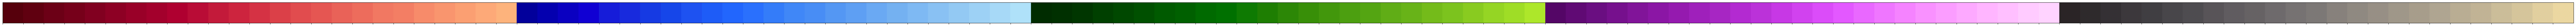

In [6]:
import seaborn as sns

sns.palplot(block_palette)

Make sure that we got 125 unique colors:

In [7]:
len(set(color_map["micro_label"].values()))

125

Save all of that:

In [8]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True).run(
    "synthetic-hierarchical",
    data=data,
    target=target_df,
    target_palette=color_map,
    tags=["synthetic", "lowdim"],
    url="https://jmlr.org/papers/v22/20-1061.html",
    verbose=True,
)

[16:20:25] INFO     Requesting one extra neighbor to account for self-neighbor        ]8;id=192471;file:///home/james/dev/drnb-plugin/src/drnb/neighbors/compute.py\compute.py]8;;\:]8;id=69852;file:///home/james/dev/drnb-plugin/src/drnb/neighbors/compute.py#613\613]8;;\

           INFO     Initial data shape: (62500, 50)                                   ]8;id=917063;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=173251;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py#83\83]8;;\

           INFO     Keeping all columns                                             ]8;id=970391;file:///home/james/dev/drnb-plugin/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=345278;file:///home/james/dev/drnb-plugin/src/drnb/preprocess.py#90\90]8;;\

           INFO     Data shape after filtering columns: (62500, 50)                  ]8;id=660533;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=210114;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py#164\164]8;;\

           INFO     Removing rows with NAs                                           ]8;id=170675;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=612177;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py#145\145]8;;\

           INFO     Data shape after filtering NAs: (62500, 50)                      ]8;id=70264;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=419013;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py#156\156]8;;\

           INFO     Checked for duplicates: found 0                                  ]8;id=202647;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=289432;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py#172\172]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}     ]8;id=17799;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=18269;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py#187\187]8;;\

           INFO     Writing data for synthetic-hierarchical                          ]8;id=742014;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=554687;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py#298\298]8;;\

           INFO     Exporting data of type ndarray to npy                            ]8;id=703363;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=678837;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#659\659]8;;\

           INFO     Exporting data of type ndarray to csv                            ]8;id=28331;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=532537;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#659\659]8;;\

[16:20:31] INFO     Processing target with initial shape (62500, 3)                  ]8;id=42496;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=621042;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py#243\243]8;;\

           INFO     Keeping all columns                                             ]8;id=530676;file:///home/james/dev/drnb-plugin/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=782722;file:///home/james/dev/drnb-plugin/src/drnb/preprocess.py#90\90]8;;\

           INFO     Writing target for synthetic-hierarchical                        ]8;id=625616;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=667103;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py#298\298]8;;\

           INFO     Exporting data of type DataFrame to feather                      ]8;id=236705;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=485263;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#659\659]8;;\

           INFO     Exporting data of type DataFrame to csv                          ]8;id=675034;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=349312;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#659\659]8;;\

           INFO     Writing JSON format to                                           ]8;id=673327;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=448157;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#494\494]8;;\
                    data/synthetic-hierarchical-target-palette.json                                 

           INFO     Calculating nearest neighbors                                    ]8;id=705043;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=516840;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py#317\317]8;;\

[16:20:35] INFO     Using 'faiss' to find nearest neighbors                           ]8;id=929966;file:///home/james/dev/drnb-plugin/src/drnb/neighbors/compute.py\compute.py]8;;\:]8;id=741879;file:///home/james/dev/drnb-plugin/src/drnb/neighbors/compute.py#263\263]8;;\

           INFO     Finding 151 neighbors using plugin faiss with euclidean metric    ]8;id=244932;file:///home/james/dev/drnb-plugin/src/drnb/neighbors/compute.py\compute.py]8;;\:]8;id=803349;file:///home/james/dev/drnb-plugin/src/drnb/neighbors/compute.py#123\123]8;;\
                    and params: {'use_gpu': True}                                                   

           INFO     [nn-plugin:faiss] launching: /home/james/.local/bin/uv run       ]8;id=475798;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=643376;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#188\188]8;;\
                    --color never --quiet drnb-nn-plugin-run.py --method faiss                      
                    --request /tmp/drnb-nn-faiss-rg38xmim/request.json                              

           INFO     [faiss] request metric=euclidean n_neighbors=151                 ]8;id=113072;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=197697;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [faiss] params={'use_gpu': True}                                 ]8;id=570305;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=655823;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

[16:20:53] INFO     Writing numpy format to                                          ]8;id=510224;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=558530;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#432\432]8;;\
                    nn/synthetic-hierarchical.16.euclidean.exact.faiss.idx.npy                      

[16:20:55] INFO     Writing csv format to                                            ]8;id=99037;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=381811;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#404\404]8;;\
                    nn/synthetic-hierarchical.16.euclidean.exact.faiss.idx.csv                      

[16:20:56] INFO     Writing numpy format to                                          ]8;id=986738;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=766275;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#432\432]8;;\
                    nn/synthetic-hierarchical.16.euclidean.exact.faiss.dist.npy                     

[16:20:58] INFO     Writing csv format to                                            ]8;id=986010;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=735545;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#404\404]8;;\
                    nn/synthetic-hierarchical.16.euclidean.exact.faiss.dist.csv                     

[16:21:00] INFO     Writing numpy format to                                          ]8;id=321848;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=653789;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#432\432]8;;\
                    nn/synthetic-hierarchical.51.euclidean.exact.faiss.idx.npy                      

[16:21:05] INFO     Writing csv format to                                            ]8;id=721765;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=749026;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#404\404]8;;\
                    nn/synthetic-hierarchical.51.euclidean.exact.faiss.idx.csv                      

[16:21:09] INFO     Writing numpy format to                                          ]8;id=737043;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=474833;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#432\432]8;;\
                    nn/synthetic-hierarchical.51.euclidean.exact.faiss.dist.npy                     

[16:21:14] INFO     Writing csv format to                                            ]8;id=941140;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=560005;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#404\404]8;;\
                    nn/synthetic-hierarchical.51.euclidean.exact.faiss.dist.csv                     

[16:21:19] INFO     Writing numpy format to                                          ]8;id=562538;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=899766;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#432\432]8;;\
                    nn/synthetic-hierarchical.151.euclidean.exact.faiss.idx.npy                     

           INFO     Writing csv format to                                            ]8;id=700446;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=993575;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#404\404]8;;\
                    nn/synthetic-hierarchical.151.euclidean.exact.faiss.idx.csv                     

[16:21:30] INFO     Writing numpy format to                                          ]8;id=337212;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=322253;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#432\432]8;;\
                    nn/synthetic-hierarchical.151.euclidean.exact.faiss.dist.npy                    

           INFO     Writing csv format to                                            ]8;id=901029;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=454837;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#404\404]8;;\
                    nn/synthetic-hierarchical.151.euclidean.exact.faiss.dist.csv                    

[16:21:43] INFO     Calculating triplets                                             ]8;id=899467;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=205480;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py#331\331]8;;\

[16:21:44] INFO     Writing csv format to                                            ]8;id=198562;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=268119;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#404\404]8;;\
                    triplets/synthetic-hierarchical.5.1337.idx.csv                                  

[16:21:46] INFO     Writing csv format to                                            ]8;id=995299;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=274616;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#404\404]8;;\
                    triplets/synthetic-hierarchical.5.1337.euclidean.csv                            

[16:21:48] INFO     Writing numpy format to                                          ]8;id=221760;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=121892;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#432\432]8;;\
                    triplets/synthetic-hierarchical.5.1337.idx.npy                                  

           INFO     Writing numpy format to                                          ]8;id=313010;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=836594;file:///home/james/dev/drnb-plugin/src/drnb/io/__init__.py#432\432]8;;\
                    triplets/synthetic-hierarchical.5.1337.euclidean.npy                            

           INFO     Writing pipeline result for synthetic-hierarchical               ]8;id=517108;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=368646;file:///home/james/dev/drnb-plugin/src/drnb/io/pipeline.py#134\134]8;;\

Let's quickly test how the colors look. Based on the Duke page, PCA does a good enough job of 
separating the clusters, and it's fast, so let's use that:

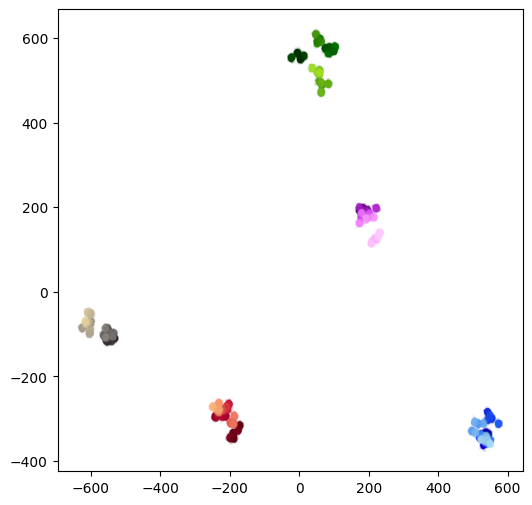

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.8688864000000002), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.9060057997703552, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.03306133333333333), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.09539008), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.24007349333333328), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [9]:
import drnb.embed.pipeline as pl

pl.standard_eval(
    method="pca",
    dataset="synthetic-hierarchical",
    extra_plot={"show_axes": True, "figsize": (6, 6)},
)

Looks close enough to the "real" results to me up to a flip in the x-values, which is just how it is
with PCA.